In [5]:
# requirement
!pip install akshare
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Reading Stocks

In [16]:
# loading packages (pip/pip3 list for new packages) - https://github.com/akfamily/akshare
# pip install akshare --upgrade
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import akshare as ak 

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS' #显示中文
# plt.rcParams['font.sans-serif'] = ['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
df_raw = ak.stock_zh_a_spot()

In [4]:
df_raw.columns

Index(['代码', '名称', '最新价', '涨跌额', '涨跌幅', '买入', '卖出', '昨收', '今开', '最高', '最低',
       '成交量', '成交额', '时间戳'],
      dtype='object')

In [5]:
df_raw.head

<bound method NDFrame.head of             代码    名称     最新价   涨跌额    涨跌幅      买入      卖出      昨收      今开  \
0     bj430017  星昊医药   13.00  0.10  0.775   12.99   13.00   12.90   12.85   
1     bj430047  诺思兰德   17.18 -0.17 -0.980   17.18   17.19   17.35   17.19   
2     bj430090  同辉信息    3.88 -0.06 -1.523    3.88    3.89    3.94    3.86   
3     bj430139  华岭股份   11.93 -0.05 -0.417   11.93   11.97   11.98   12.00   
4     bj430198  微创光电    8.47 -0.12 -1.397    8.47    8.48    8.59    8.63   
...        ...   ...     ...   ...    ...     ...     ...     ...     ...   
5350  sz301577  美信科技   61.75 -0.71 -1.137   61.75   61.77   62.46   61.60   
5351  sz301578  辰奕智能   58.16 -0.39 -0.666   58.16   58.18   58.55   58.05   
5352  sz301588  美新科技   31.10 -1.40 -4.308   31.10   31.11   32.50   31.90   
5353  sz301589  诺瓦星云  476.66 -8.42 -1.736  476.63  476.66  485.08  482.82   
5354  sz301591  肯特股份   50.75 -0.35 -0.685   50.75   50.76   51.10   51.30   

          最高      最低        成交量          成交额 

In [9]:
df = df_raw[['代码','名称']].copy()
df.rename(columns={'代码': 'symbol', '名称': 'name'}, inplace=True)
symbol_name_dict = df.set_index('symbol')['name'].to_dict()
# symbol_name_dict.get('sh600029')

In [10]:
today = datetime.now().date().strftime("%Y-%m-%d")
start_date, end_date ="2023-06-01",today
stock_list = ['sh600887','sh600009','sh600029','sh600004','sz000651']

def get_signal(stock_index):

    stock_data = ak.stock_zh_a_daily(symbol=stock_index, start_date=start_date, end_date=end_date)
    # 计算5日和20日均线
    stock_data["ma5"] = stock_data["close"].rolling(window=5).mean()
    stock_data["ma20"] = stock_data["close"].rolling(window=20).mean()
    # 生成买入/卖出信号（ma5向上穿越ma20/ma5向下穿越ma20）
    stock_data["buy_signal"] = (stock_data["ma5"] > stock_data["ma20"]) & (stock_data["ma5"].shift(1) <= stock_data["ma20"].shift(1))
    stock_data["sell_signal"] = (stock_data["ma5"] < stock_data["ma20"]) & (stock_data["ma5"].shift(1) >= stock_data["ma20"].shift(1))

    return stock_data

##### Visualisation

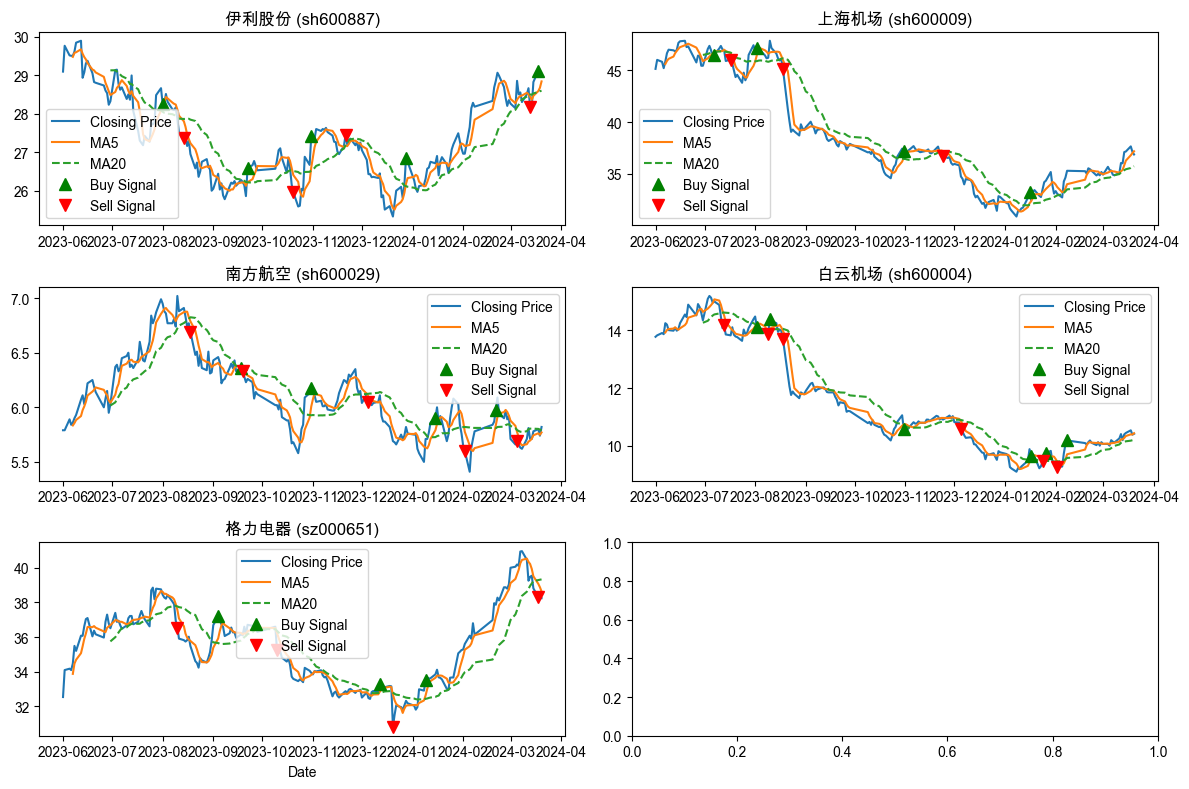

In [13]:
# Create a figure and axes for the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns

for i, stock_index in enumerate(stock_list):
    stock_data = get_signal(stock_index)
    stock_name = symbol_name_dict.get(stock_index)
    # print(f'{stock_name}: {stock_index}\n')
    
    # Calculate the subplot position
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    
    # Retrieve the corresponding subplot axes
    ax = axs[row, col]

    # Convert the index into datetime
    stock_data.index = pd.to_datetime(stock_data['date'], format='%Y-%m-%d')
    
    # Plot the closing prices
    ax.plot(stock_data.index, stock_data["close"], label="Closing Price")
    
    # Plot the moving averages (ma5 and ma20)
    ax.plot(stock_data.index, stock_data["ma5"], linestyle='-', label="MA5")
    ax.plot(stock_data.index, stock_data["ma20"], linestyle='--', label="MA20")
    
    # Plot the buy and sell signals
    ax.plot(stock_data[stock_data['buy_signal']]['date'], stock_data[stock_data['buy_signal']]['close'], 'g^', markersize=8, label='Buy Signal')
    ax.plot(stock_data[stock_data['sell_signal']]['date'], stock_data[stock_data['sell_signal']]['close'], 'rv', markersize=8, label='Sell Signal')

    # Set the subplot title and legend
    ax.set_title(f"{stock_name} ({stock_index})")
    ax.legend()
    
    # Set the x-axis label only for the bottom subplots
    if row == 2:
        ax.set_xlabel("Date")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [7]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[1], start_date=start_date, end_date=end_date)
stock_data

NameError: name 'stock_list' is not defined

#### Modelling - LSTM

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[1], start_date=start_date, end_date=end_date)
# Convert the date column to datetime format
stock_data["date"] = pd.to_datetime(stock_data["date"])

# Sort the data by date in ascending order
stock_data.sort_values("date", inplace=True)

# Normalize the closing price values between 0 and 1
scaler = MinMaxScaler()
stock_data["close_scaled"] = scaler.fit_transform(stock_data["close"].values.reshape(-1, 1))

##### Training

In [26]:
# Split the data into training and testing sets
train_size = int(len(stock_data) * 0.9)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

# Create input sequences and corresponding target values for training
X_train = []
y_train = []

# Define the number of previous time steps to consider
# (e.g., use the previous 5 days' closing prices to predict the next day)
time_steps = 5

for i in range(time_steps, len(train_data)):
    X_train.append(train_data["close_scaled"].values[i - time_steps:i])
    y_train.append(train_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match the LSTM layer input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create input sequences and corresponding target values for testing
X_test = []
y_test = []

for i in range(time_steps, len(test_data)):
    X_test.append(test_data["close_scaled"].values[i - time_steps:i])
    y_test.append(test_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM layer input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
# Initialize the model
model = Sequential()

# Add an LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))

# Add another LSTM layer with 50 units
model.add(LSTM(units=50))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


/Users/yuanchen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3175  
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1635 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0619 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

##### Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


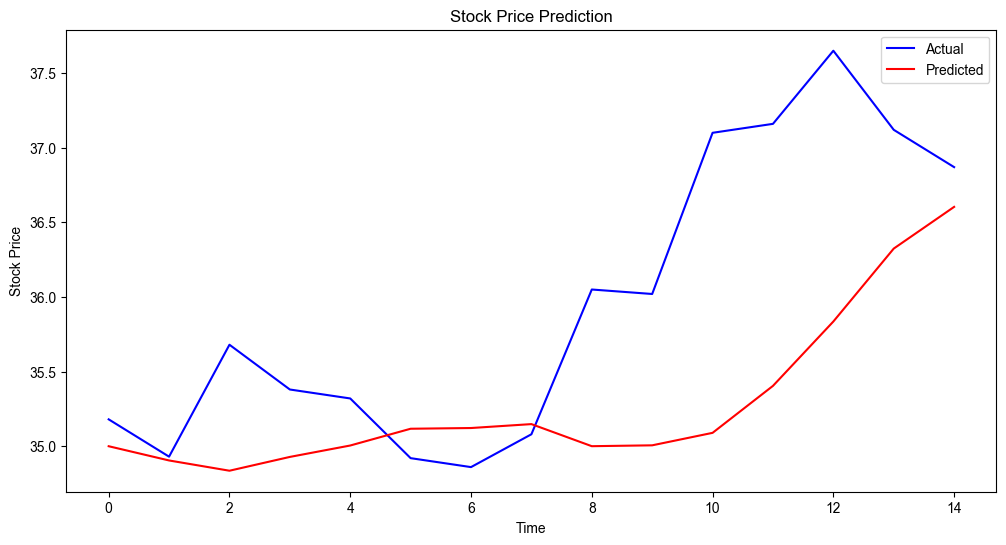

In [28]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original range
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

##### # read more on https://zhuanlan.zhihu.com/p/678521592